In [410]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import Pauli, random_unitary
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
from qiskit import BasicAer
from qiskit.opflow import Zero, H, Z,PauliTrotterEvolution,Suzuki,MatrixEvolution
from qiskit.quantum_info.analysis import average_data
import pandas as pd

In [411]:
def EncoderCircuit(x1, x2):
    circ = QuantumCircuit(2)
    circ.h(range(0,2))
    circ.rz(-2*x1,0)
    circ.rz(-2*x2,1)
    zz = (np.pi-x1)*(np.pi-x2)
    circ.rzz(-2*zz, 0,1)
    circ.h(range(0,2))
    circ.rz(-2*x1,0)
    circ.rz(-2*x2,1)
    circ.rzz(-2*zz, 0,1)
    return circ

In [386]:
def AddLabelMeasurements(x1, x2, matrix):
    circ = EncoderCircuit(x1, x2)
    circ.hamiltonian(matrix, 1, [0,1])
    circ.measure_all(inplace=True)
    return circ

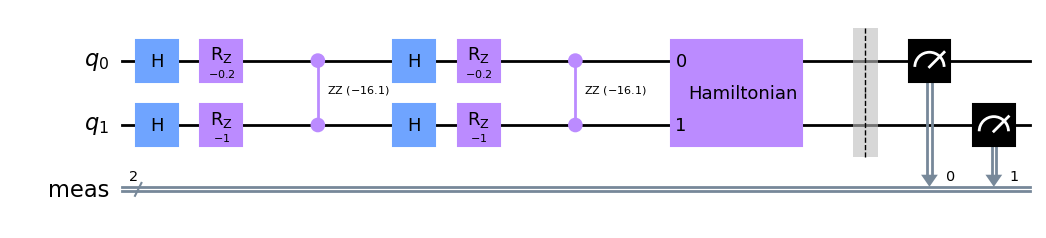

In [413]:
m1 = np.array([[0, 1-1j, 0, 0], [1+1j, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
AddLabelMeasurements(0.1, 0.5, m1).draw(output='mpl')

In [388]:
def GenerateLabel(x1, x2, matrix):
    circ = AddLabelMeasurements(x1, x2, matrix)
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circ, backend, shots=2048)
    counts = job.result().get_counts(circ)
    expectation = average_data(counts,  [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # TODO: is this right?
    return expectation

In [389]:
iteration = 1200
label_num = 20
df = pd.DataFrame([], columns=['x1', 'x2', 'y', 'label'])

# m1 = np.array([[0, 1-1j, 0, 0], [1+1j, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
# m2 = np.array([[0, 1-1j, 1, -1j], [1+1j, 0, 0, 0], [1, 0, 0, 0], [1j, 0, 0, 0]])
# m3 = np.array([[2, 0, 0, 0], [0, 0, 2, 0], [0, 2, 1, -1j], [0, 0, 1j, -3]])
matrix = np.array([[2, 0, 0, 0], [0, 0, 2, 0], [0, 2, 1, -1j], [0, 0, 1j, -3]])
matrices = [matrix]

np.random.seed(1234)

for m in matrices: 
    neg_num = 0
    pos_num = 0
    for i in range(0, iteration):
        if pos_num > label_num and neg_num > label_num:
            break
        x1 = random.uniform(0, 2*np.pi)
        x2 = random.uniform(0, 2*np.pi)
        y = GenerateLabel(x1, x2, m)
        if y >= 0.3:
            if pos_num < label_num:
                df.loc[len(df.index)] = [x1, x2, y, 1] 
                pos_num += 1
            else: 
                continue
        elif y <= -0.3:
            if neg_num < label_num:
                df.loc[len(df.index)] = [x1, x2, y, -1] 
                neg_num += 1
            else: 
                continue
    if pos_num < label_num or neg_num < label_num:
        print('did not get enough data for {}'.format(m))

In [390]:
# df.to_csv("generated_data/m3_train_2.csv")

In [391]:
full_df = pd.DataFrame([], columns=['x1', 'x2', 'y', 'label'])
for x1 in np.linspace(0, 2 * np.pi, num=50):
    for x2 in np.linspace(0, 2 * np.pi, num=50):
        y = GenerateLabel(x1, x2, matrix)
        if y >= 0.3:
            full_df.loc[len(full_df.index)] = [x1, x2, y, 1] 
        elif y <= -0.3:
            full_df.loc[len(full_df.index)] = [x1, x2, y, -1] 

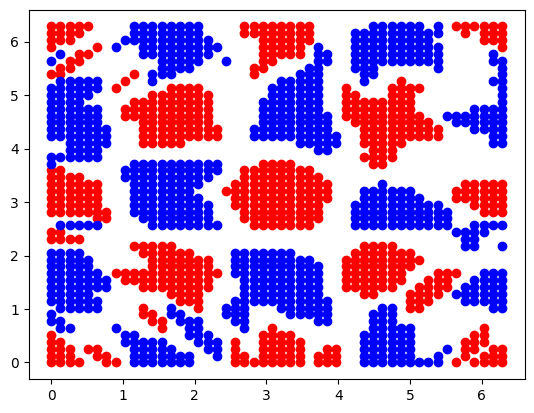

In [392]:
plt.scatter(full_df[full_df['label']==1.0]['x1'],full_df[full_df['label']==1.0]['x2'], color='red')
plt.scatter(full_df[full_df['label']==-1.0]['x1'],full_df[full_df['label']==-1.0]['x2'], color='blue')
# plt.savefig('generated_data.png')

In [393]:
# full_df.to_csv("generated_data/m3_test_2.csv")